In [1]:
# ====================================================
# Library
# ====================================================
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from itertools import combinations
import itertools

In [2]:
train = pd.read_parquet('../input/train_fe.parquet')
test = pd.read_parquet('../input/test_fe.parquet')

In [3]:
train = train[['customer_ID', 'P_2_last', 'D_39_last', 'target']] #, 'P_2_last', 'D_39_last'
test = test[['customer_ID', 'P_2_last', 'D_39_last']]

In [4]:
test.head()

,customer_ID,P_2_last,D_39_last
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.568930,4
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.841177,4
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.697522,0
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.513186,11
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.254478,26


In [2]:
# Metric:

def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

# ====================================================
# LGBM amex metric
# ====================================================
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True

In [6]:
oof_new = pd.read_csv('../lgbm_new_5_fold/oof_lgbm_new_5_fold_seed42.csv')
oof_smn = pd.read_csv('../lgbm_smn_fold/oof_lgbm_smn_fold_seed42.csv')
#oof_lag = pd.read_csv('../lgbm_lag_5_fold/oof_lgbm_lag_5_fold_5fold_seed42.csv')
oof_xgb = pd.read_csv('../xgb_fe_8_fold/oof_xgb_fe_8_fold_seed42.csv')
oof_xgb_smn = pd.read_csv('../xgb_smn_5_fold/oof_xgb_smn_5_fold_seed42.csv')
#oof_bobw = pd.read_csv('../xgb_BOBW_5_fold/oof_xgb_BOBW_5_fold_seed42.csv')

In [7]:
train['pred_new'] = oof_new.prediction
train['pred_smn'] = oof_smn.prediction
#train['pred_lag'] = oof_lag.prediction
train['pred_xgb'] = oof_xgb.prediction
train['pred_xgb_smn'] = oof_xgb_smn.prediction
#train['pred_xgb_bobw'] = oof_bobw.prediction

In [8]:
train = train[['customer_ID' , 'P_2_last', 'D_39_last', 'pred_new', 'pred_smn', 'pred_xgb','pred_xgb_smn', 'target']] #'pred_lag',  'pred_xgb_bobw',

In [9]:
train.head()

,customer_ID,P_2_last,D_39_last,pred_new,pred_smn,pred_xgb,pred_xgb_smn,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.934745,0,0.000307,0.000128,0.000262,0.000162,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.880519,6,0.000957,0.000704,0.001429,0.001026,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.880875,0,0.001072,0.001070,0.001446,0.001510,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0.621776,0,0.003317,0.001992,0.008611,0.003684,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0.871900,0,0.001673,0.000634,0.000680,0.001328,0


In [10]:
test_new = pd.read_csv('../lgbm_new_5_fold/test_lgbm_new_5_fold_seed42.csv')
test_smn = pd.read_csv('../lgbm_smn_fold/test_lgbm_smn_fold_seed42.csv')
#test_lag = pd.read_csv('../lgbm_lag_5_fold/test_lgbm_lag_5_fold_5fold_seed42.csv')
test_xgb = pd.read_csv('../xgb_fe_8_fold/test_xgb_fe_8_fold_seed42.csv')
test_xgb_smn = pd.read_csv('../xgb_smn_5_fold/test_xgb_smn_5_fold_seed42.csv')
#test_xgb_bobw = pd.read_csv('../xgb_BOBW_5_fold/test_xgb_BOBW_5_fold_seed42.csv')

In [11]:
test['pred_new'] = test_new.prediction
test['pred_smn'] = test_smn.prediction
#test['pred_lag'] = test_lag.prediction
test['pred_xgb'] = test_xgb.prediction
test['pred_xgb_smn'] = test_xgb_smn.prediction
#test['pred_xgb_bobw'] = test_xgb_bobw.prediction

In [12]:
from scipy.stats import ks_2samp

#perform Kolmogorov-Smirnov test
ks_2samp(test_xgb.prediction, test_new.prediction)

KstestResult(statistic=0.057840996473149525, pvalue=0.0)

In [13]:
test.head()

,customer_ID,P_2_last,D_39_last,pred_new,pred_smn,pred_xgb,pred_xgb_smn
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.568930,4,0.029524,0.028134,0.032877,0.024319
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.841177,4,0.001012,0.000574,0.000531,0.000385
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.697522,0,0.038608,0.025484,0.033457,0.027844
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.513186,11,0.179223,0.200430,0.153475,0.156202
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.254478,26,0.869733,0.905022,0.920015,0.925976


In [14]:

# ====================================================
# Configurations
# ====================================================
class CFG:
    input_dir = '../input/'
    seed = 42
    n_folds = 5
    target = 'target'
    boosting_type = 'dart'
    metric = 'binary_logloss'

# ====================================================
# Seed everything
# ====================================================
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [15]:
# ====================================================
# Directory settings
# ====================================================
import os

expt_name = "stacking_lgbm_6"
OUTPUT_DIR = f'../{expt_name}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [16]:
# ====================================================
# Train & Evaluate
# ====================================================
def train_and_evaluate(train, test):

    # Get feature list
    features = [col for col in train.columns if col not in ['customer_ID', CFG.target]]
    params = {
        'objective': 'binary',
        'metric': CFG.metric,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        'max_depth': 3,
        'num_leaves': 15,
        'learning_rate': 0.01,
        #'feature_fraction': 0.20,
        'bagging_freq': 10,
        'bagging_fraction': 0.5,
        'n_jobs': -1,
        'lambda_l2': 2,
        'path_smooth': 20, #added new
        'min_data_in_leaf': 40, #changed from 40
        'force_col_wise': True
        #'device': 'gpu',
        #'max_bin': 255,
        #'gpu_platform_id': 1,
        #'gpu_device_id': 0
        }
    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))
    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
        print(' ')
        print('-'*50)
        print(f'Training fold {fold} with {len(features)} features...')
        x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
        y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_valid = lgb.Dataset(x_val, y_val)

        model = lgb.train(
            params = params,
            train_set = lgb_train,
            num_boost_round = 3000,
            valid_sets = [lgb_train, lgb_valid],
            #early_stopping_rounds = 500,
            verbose_eval = 100,
            feval = lgb_amex_metric)
        # Save best model
        joblib.dump(model, OUTPUT_DIR+f'stacking_lgbm_fold{fold}.pkl')
        # Predict validation
        val_pred = model.predict(x_val)
        # Add to out of folds array
        oof_predictions[val_ind] = val_pred
        # Predict the test set
        test_pred = model.predict(test[features])
        test_predictions += test_pred / CFG.n_folds
        # Compute fold metric
        score = amex_metric(y_val, val_pred)
        print(f'------------fold {fold} CV score is {score}--------------')
        del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
        gc.collect()
    # Compute out of folds metric
    score = amex_metric(train[CFG.target], oof_predictions)
    print(f'Out of folds CV score is {score}')
    # Create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
    oof_df.to_csv(OUTPUT_DIR+f'oof_{expt_name}_seed{CFG.seed}.csv', index = False)
    # Create a dataframe to store test prediction
    test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
    test_df.to_csv(OUTPUT_DIR+f'test_{expt_name}_seed{CFG.seed}.csv', index = False)


seed_everything(CFG.seed)
#train, test = read_data()
train_and_evaluate(train, test)

 
--------------------------------------------------
Training fold 0 with 6 features...
[LightGBM] [Info] Number of positive: 95062, number of negative: 272068
[LightGBM] [Info] Total Bins 1391
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051523
[LightGBM] [Info] Start training from score -1.051523
[100]	training's binary_logloss: 0.451621	training's amex_metric: 0.795514	valid_1's binary_logloss: 0.450765	valid_1's amex_metric: 0.801315
[200]	training's binary_logloss: 0.429189	training's amex_metric: 0.795818	valid_1's binary_logloss: 0.428083	valid_1's amex_metric: 0.802361
[300]	training's binary_logloss: 0.372638	training's amex_metric: 0.795987	valid_1's binary_logloss: 0.371162	valid_1's amex_metric: 0.803498
[400]	training's binary_logloss: 0.346793	training's amex_metric: 0.796171	valid_1's binary_logloss: 0.345146	valid_1's amex_metric: 0.802958
[500]	train

In [6]:
stacking = pd.read_csv('../stacking_lgbm_6/oof_stacking_lgbm_6_seed42.csv')
stacking.head()

,customer_ID,target,prediction
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,0.000839
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0,0.001459
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0,0.001751
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0,0.004509
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0,0.001423


In [7]:
amex_metric(stacking.target, stacking.prediction)

0.79838162990107

In [29]:
stacking_6 = pd.read_csv('../stacking_lgbm_6/test_stacking_lgbm_6_seed42.csv')
stacking_5 = pd.read_csv('../stacking_lgbm_5/test_stacking_lgbm_5_seed42.csv')
df = pd.read_csv('../stacking_lgbm_5/submission.csv')
df_clipped = pd.read_csv('../stacking_lgbm_5/submission_clipped.csv')
best = pd.read_csv('../stacking_lgbm_5/submission_best.csv')

In [18]:
df_clipped.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.014540
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000340
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.026672
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.193853
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.853768


In [30]:
ks_2samp(stacking_6.prediction, stacking_5.prediction)

KstestResult(statistic=0.04997074477001928, pvalue=0.0)

In [26]:
ks_2samp(stacking.prediction, best.prediction)

KstestResult(statistic=0.5417116851120621, pvalue=0.0)

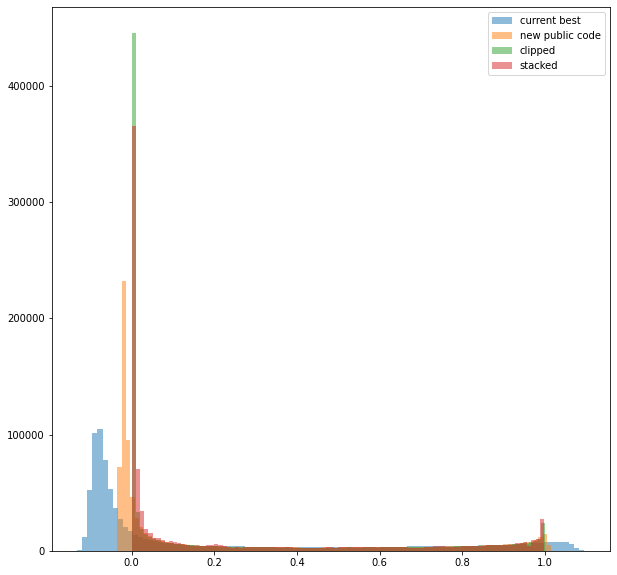

In [21]:
plt.figure(figsize=(10,10))
plt.hist(best.prediction, bins = 100, alpha=0.5, label='current best')
plt.hist(df.prediction, bins = 100, alpha=0.5, label='new public code')
plt.hist(df_clipped.prediction, bins = 100, alpha=0.5, label='clipped')
plt.hist(test_df.prediction, bins = 100, alpha=0.5, label='stacked')
plt.legend(loc='best')

plt.show()

In [22]:
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)
plt.hist(best.prediction, bins=100)
plt.title('Test Predictions')
plt.show()

NameError: name 'ax1' is not defined